## Importazione e preprocessing

### Importazione pacchetti

In [1]:
#Stile di visualizzazione plot fatti con matplotlib
%matplotlib inline

#Base
import os
import pandas as pd
import numpy as np
import scipy as sp
import time
import sys

#Visualizzazione
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sn  #Per heatmap

#Preprocessing e altro
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, ParameterGrid

#Modelli
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC as SupportVectorMachineClassifier
from sklearn.neural_network import MLPClassifier

#Metriche
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, make_scorer

#Pre-processing
sys.path.insert(1, '../Data')
from preprocessing import preprocessing_diabetes

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

### Importazione dati

In [3]:
trainingData = pd.read_csv('../Data/diabetes_train.csv')
testData = pd.read_csv('../Data/diabetes_test.csv')

In [4]:
df_train_scal, df_test_scal, y_train, y_test = preprocessing_diabetes(trainingData, testData)
df_train_noFeat, df_test_noFeat, _, _ = preprocessing_diabetes(trainingData, testData, option='Delete')
df_train_PCA, df_test_PCA, _, _ = preprocessing_diabetes(trainingData, testData, option='PCA')

#No smoking
df_train_noSmok = df_train_scal[[col for col in df_train_scal.columns if 'smoking' not in col]]
df_test_noSmok = df_test_scal[[col for col in df_test_scal.columns if 'smoking' not in col]]

In [5]:
display(df_train_scal)

,age,bmi,HbA1c_level,blood_glucose_level,Insulin_Sensitivity_Est,BMI_Glucose_Interaction,Random_Lab_Marker,gender,hypertension,heart_disease,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0.894928,-0.176195,0.503722,0.095442,0.476212,-0.055814,-1.175480,1,0,0,False,False,False,True,False
1,0.668110,0.758421,1.541394,-0.072366,0.007480,0.266092,-1.007407,1,1,0,False,False,False,True,False
2,1.034925,0.365698,2.218108,1.701715,0.481892,1.438787,0.651317,1,0,0,False,False,True,False,False
3,0.579111,0.667063,2.104176,0.043478,0.716419,0.317432,-0.953973,1,0,0,False,False,False,True,False
4,1.146937,1.446470,0.321064,0.328064,-0.132528,0.907586,0.423327,1,0,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,-1.205383,0.064420,-0.402472,0.164156,0.179832,0.206146,0.311464,0,0,0,False,False,True,False,False
582,1.134089,-0.535417,-1.650545,0.127452,-2.138018,-0.213306,-0.655270,0,0,0,False,False,False,False,True
583,0.672161,0.122466,-0.008653,-0.142200,-1.439506,-0.080177,0.943590,1,0,1,True,False,False,False,False
584,-0.852201,-0.142217,0.134120,0.917149,0.000000,0.521425,1.180482,0,0,0,False,False,False,False,False


## Multi-Layer Perceptron

In [6]:
random_seed = 42

In [7]:
# Creazione di una sottomappa di viridis, in modo da avere il verde come massimo
viridis = matplotlib.colormaps['viridis'].resampled(280)
newcolors = viridis(np.linspace(0, 1, 280))[:210]
newcmp=matplotlib.colors.ListedColormap(newcolors)

In [8]:
def performances(model,data,y_true,title=None):
    start=time.time()
    y_pred=model.predict(data)
    stop=time.time()
    totalTime=stop-start
    acc = model.score(data, y_true)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    df = pd.DataFrame({'Accuracy': [acc], 
                        'Precision': [prec ], 
                        'Recall': [rec ],
                        'F1': [f1 ]
                       },
                      index=[title])
    cmat=pd.DataFrame(confusion_matrix(y_true,y_pred,labels=model.classes_))
    return df,cmat,totalTime

In [35]:
def heatMapConstr(heatMapMatrices, titles):
    fig,axs=plt.subplots(1,2,figsize=(10,3))
    for i in range(2):
        normMatrix=heatMapMatrices[i].div(heatMapMatrices[i].sum(axis=1), axis=0)
        ax=axs[i]
        im=ax.imshow(normMatrix,vmin=0,vmax=1,cmap=newcmp)
        ax.set_yticks(range(len(heatMapMatrices[i].index)))
        ax.set_yticklabels(heatMapMatrices[i].index)
        ax.set_xticks(range(len(heatMapMatrices[i].columns)))
        ax.set_xticklabels(heatMapMatrices[i].columns)
        ax.title.set_text(titles[i])
        ax.set_xlabel("predicted")
        ax.set_ylabel("true")
        for a in range(len(heatMapMatrices[i].index)):
            for j in range(len(heatMapMatrices[i].columns)):
                text = ax.text(j, a, heatMapMatrices[i].iloc[a, j], ha="center", va="center", color='w')
    #plt.savefig('Confusion_matrices_mlp_ig',dpi=300)
    fig.tight_layout()
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    #plt.savefig('gs_SVM_'+scoreInterest,dpi=300)
    plt.show()

In [10]:
def heatMapGridSearch(modelResults, gridDict, scoreInterest):  # mean_test_score, mean_train_score, mean_fit_time
    vmin=modelResults[scoreInterest].min()
    vmax=1
    if scoreInterest=='time':
        vmax=modelResults[scoreInterest].max()

    fig,axs=plt.subplots(1,len(gridDict['batch_size']),figsize=(15,4))
    for i,bs in enumerate(gridDict['batch_size']):
        square=pd.DataFrame()
        for act in gridDict['activation']:
            col=pd.DataFrame()
            for alp in gridDict['alpha']:
                df = modelResults[modelResults['param_batch_size']==bs][modelResults['param_activation']==act][modelResults['param_alpha']==alp][modelResults['param_learning_rate']=='constant']
                df=df.pivot(index='layers', columns='layerSize', values=scoreInterest)
                col=pd.concat([col,df])
            square=pd.concat([square,col], axis=1)

        ax=axs[i]
        im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
        ax.set_yticks(range(len(square.index)))
        ax.set_yticklabels(square.index)
        ax.set_xticks(range(len(square.columns)))
        ax.set_xticklabels(square.columns)
        #ax.title.set_text(bs)
        ax.set_xlabel("layerSize")
        ax.set_ylabel("layers")
        for a in range(len(square.index)):
            for j in range(len(square.columns)):
                c="w"
                if square.iloc[a, j]==modelResults[scoreInterest].max():
                    c="red"
                elif square.iloc[a, j]==square.values.max():
                    c="gold"
                text = ax.text(j, a, "{0:.2f}".format(square.iloc[a, j]),
                            ha="center", va="center", color=c)
        #Linee verticali e orizzontali di separazione
        ax.axhline(y=3.5,c="black",linewidth=0.75,zorder=0)
        ax.axvline(x=3.5,c="black",linewidth=0.75,zorder=0)
        #Testi aggiuntivi degli assi mancanti e titolo
        ax.text(3.5, -1.5, 'batchSize = '+str(bs), ha="center", va="center", fontsize=12)
        ax.text(8.25, 3.5, 'alpha', ha="center", va="center", rotation='vertical')
        ax.text(1.5, -0.75, gridDict['activation'][0], ha="center", va="center")
        ax.text(5.5, -0.75, gridDict['activation'][1], ha="center", va="center")
        ax.text(7.75, 1.5, gridDict['alpha'][0], ha="left", va="center")
        ax.text(7.75, 5.5, gridDict['alpha'][1], ha="left", va="center")

    cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    #plt.savefig('MLP_'+scoreInterest,dpi=300)
    plt.show()
    print('MIGLIORI IPERPARAMETRI')
    max_elem_row=modelResults[scoreInterest].astype(float).idxmax()
    bestModel = modelResults.iloc[max_elem_row]
    bestModelShort = bestModel[[idx for idx in bestModel.index if 'param' in idx and 'params' not in idx]+['mean_train_score','mean_test_score','mean_fit_time']]
    display(pd.DataFrame(bestModelShort).transpose())
    return bestModel

### Grid Search e train

In [ ]:
layerSize=[50,100,200,250]
layers=[1,2,3,5]
hiddenLayerSizes=[]
for i in layerSize:
    for j in layers:
        hiddenLayerSizes.append([i]*j)
print(hiddenLayerSizes)
GRID = {
    'hidden_layer_sizes': hiddenLayerSizes,
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],  #Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
    'max_iter': [1000],
    'learning_rate': ['constant'], #, 'adaptive'],
    #'n_iter_no_change': [75, 150],
    'batch_size': [10, 50, 200]
}

[[50], [50, 50], [50, 50, 50], [50, 50, 50, 50, 50], [100], [100, 100], [100, 100, 100], [100, 100, 100, 100, 100], [200], [200, 200], [200, 200, 200], [200, 200, 200, 200, 200], [250], [250, 250], [250, 250, 250], [250, 250, 250, 250, 250]]


#### Classico

In [12]:
#Dichiarazione della svm
mlp1 = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_gs = GridSearchCV(estimator=mlp1,
                      param_grid=GRID,
                      scoring='f1_weighted',
                      cv=10,
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_gs.fit(df_train_scal, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1 = pd.DataFrame(mlp1_gs.cv_results_)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


In [13]:
display(results1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.410810,0.140504,0.005790,0.001370,tanh,0.0001,10,[50],constant,1000,...,0.948702,0.952379,0.927521,0.944902,0.933456,0.948799,0.943322,0.952710,0.944371,0.007724
1,0.455468,0.172522,0.005487,0.001201,tanh,0.0001,10,"[50, 50]",constant,1000,...,0.935319,0.939279,0.950001,0.958148,0.947952,0.952710,0.944722,0.949051,0.943986,0.008824
2,0.355913,0.137261,0.005139,0.001314,tanh,0.0001,10,"[50, 50, 50]",constant,1000,...,0.933670,0.933833,0.934977,0.938802,0.934273,0.933794,0.921028,0.941643,0.933213,0.005314
3,0.667079,0.229849,0.006019,0.001954,tanh,0.0001,10,"[50, 50, 50, 50, 50]",constant,1000,...,0.947379,0.950409,0.941938,0.959892,0.958437,0.950997,0.954977,0.956385,0.950791,0.006161
4,0.205983,0.042749,0.004263,0.000217,tanh,0.0001,10,[100],constant,1000,...,0.944613,0.928747,0.919810,0.930544,0.935273,0.925453,0.927239,0.925609,0.930139,0.006497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2.310165,0.728881,0.014783,0.004221,relu,0.0500,200,"[200, 200, 200, 200, 200]",constant,1000,...,0.943489,0.962663,0.964641,0.965844,0.988578,0.971555,0.971555,0.990565,0.965250,0.015595
124,0.241266,0.070142,0.010629,0.002884,relu,0.0500,200,[250],constant,1000,...,0.920343,0.926503,0.920583,0.917761,0.916357,0.922337,0.909245,0.915586,0.918111,0.004414
125,1.022047,0.612147,0.011526,0.002683,relu,0.0500,200,"[250, 250]",constant,1000,...,0.881657,0.954101,0.963712,0.955954,0.952343,0.852427,0.832755,0.870220,0.916032,0.048466
126,1.666252,0.410082,0.012743,0.002139,relu,0.0500,200,"[250, 250, 250]",constant,1000,...,0.935484,0.930163,0.967782,0.958038,0.964235,0.958228,0.958228,0.965993,0.953932,0.014626


#### No correlation

In [14]:
#Dichiarazione della svm
mlp1_noFeat = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_noFeat_gs = GridSearchCV(estimator=mlp1_noFeat,
                      param_grid=GRID,
                      scoring='f1_weighted',
                      cv=10,
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_noFeat_gs.fit(df_train_noFeat, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noFeat = pd.DataFrame(mlp1_noFeat_gs.cv_results_)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


#### No smoking

In [15]:
#Dichiarazione della svm
mlp1_noSmok = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_noSmok_gs = GridSearchCV(estimator=mlp1_noSmok,
                      param_grid=GRID,
                      scoring='f1_weighted',
                      cv=10,
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_noSmok_gs.fit(df_train_noSmok, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noSmok = pd.DataFrame(mlp1_noSmok_gs.cv_results_)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


#### PCA

In [16]:
#Dichiarazione della svm
mlp1_PCA = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_PCA_gs = GridSearchCV(estimator=mlp1_PCA,
                      param_grid=GRID,
                      scoring='f1_weighted',
                      cv=10,
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_PCA_gs.fit(df_train_PCA, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_PCA = pd.DataFrame(mlp1_PCA_gs.cv_results_)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


### Visualizzazione

In [17]:
#Classico
results1['layers'] = results1.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1['layerSize'] = results1.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#No correlated feature
results1_noFeat['layers'] = results1_noFeat.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_noFeat['layerSize'] = results1_noFeat.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#No smoking
results1_noSmok['layers'] = results1_noSmok.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_noSmok['layerSize'] = results1_noSmok.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#PCA
results1_PCA['layers'] = results1_PCA.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_PCA['layerSize'] = results1_PCA.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)

In [18]:
results1.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_activation', 'param_alpha', 'param_batch_size',
       'param_hidden_layer_sizes', 'param_learning_rate', 'param_max_iter',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'split5_train_score', 'split6_train_score', 'split7_train_score',
       'split8_train_score', 'split9_train_score', 'mean_train_score',
       'std_train_score', 'layers', 'layerSize'],
      dtype='object')

CLASSICO


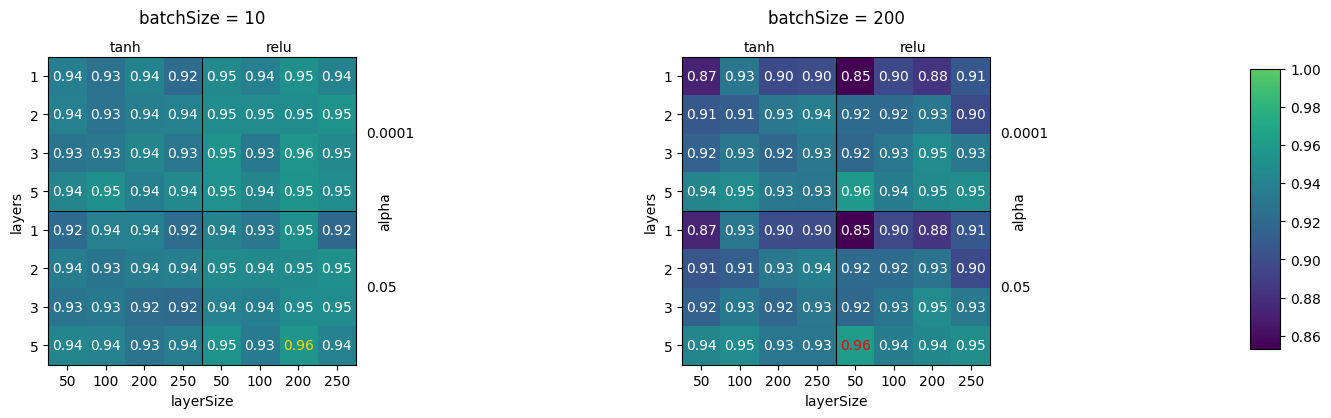

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
115,relu,0.05,200,"[50, 50, 50, 50, 50]",constant,1000,0.964975,0.960198,0.470343


NO CORRELATED FEATURE


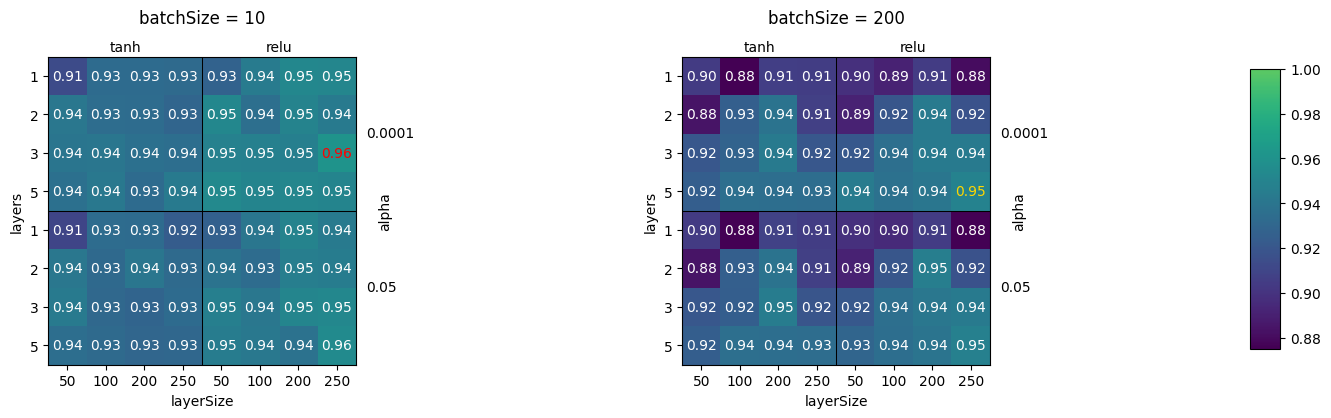

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
78,relu,0.0001,10,"[250, 250, 250]",constant,1000,0.991653,0.960337,15.651018


NO SMOKING


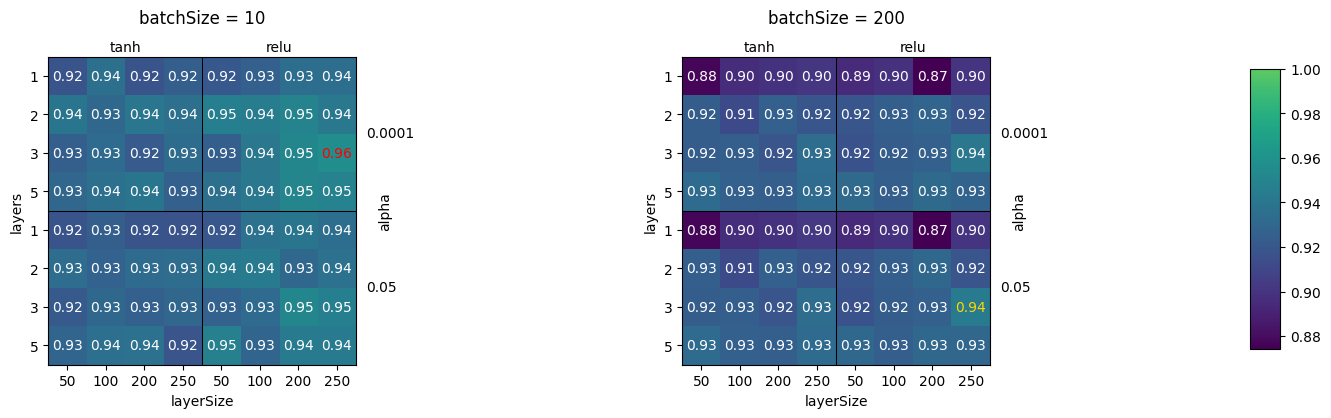

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
78,relu,0.0001,10,"[250, 250, 250]",constant,1000,0.98592,0.956635,12.709862


CON PCA


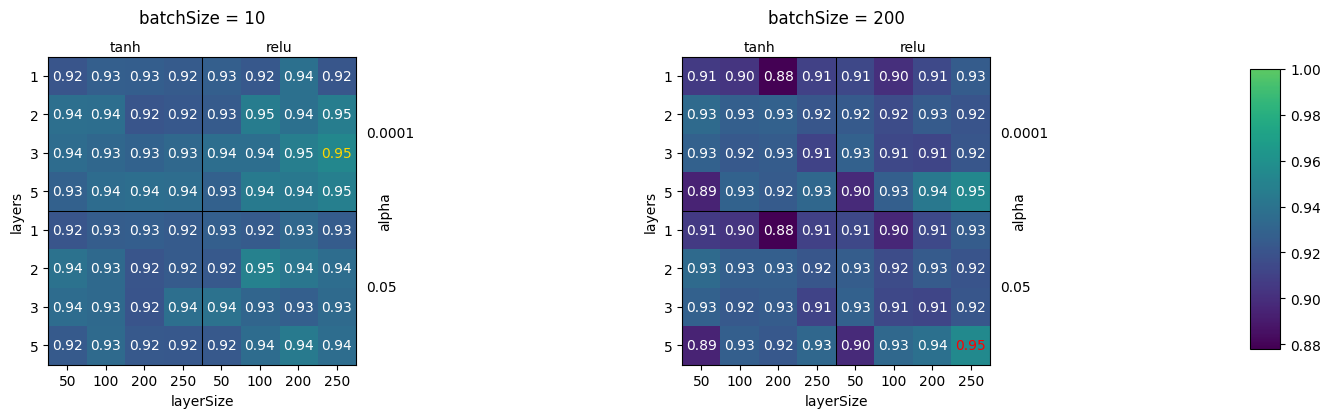

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
127,relu,0.05,200,"[250, 250, 250, 250, 250]",constant,1000,0.958486,0.954945,6.765183


In [19]:
scoreInterest='mean_test_score'
print('CLASSICO')
bestModel = heatMapGridSearch(results1, GRID, scoreInterest)
print('NO CORRELATED FEATURE')
bestModel_noFeat = heatMapGridSearch(results1_noFeat, GRID, scoreInterest)
print('NO SMOKING')
bestModel_noSmok = heatMapGridSearch(results1_noSmok, GRID, scoreInterest)
print('CON PCA')
bestModel_PCA = heatMapGridSearch(results1_PCA, GRID, scoreInterest)

### Test del modello migliore

#### Identificazione modello migliore in validation

In [20]:
bestModels_df = pd.DataFrame(np.vstack((bestModel,bestModel_noFeat,bestModel_noSmok,bestModel_PCA)), index=['Dati originali', 'No feature correlata', 'No smoking', 'PCA'], columns=bestModel.index)
display(bestModels_df[['mean_test_score', 'mean_fit_time']].rename(columns={'mean_test_score':'f1 score medio su validation', 'mean_fit_time':'Tempo medio addestramento'}))

,f1 score medio su validation,Tempo medio addestramento
Dati originali,0.960198,0.470343
No feature correlata,0.960337,15.651018
No smoking,0.956635,12.709862
PCA,0.954945,6.765183


In [26]:
#Classico
bestMLP = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel['param_hidden_layer_sizes'], activation=bestModel['param_activation'], alpha=bestModel['param_alpha'], batch_size=bestModel['param_batch_size'], max_iter=bestModel['param_max_iter'], shuffle=True)
start=time.time()
bestMLP.fit(df_train_scal,y_train)
stop=time.time()
bestMLP_fit_time = stop-start

#No correlated feature
bestMLP_noFeat = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_noFeat['param_hidden_layer_sizes'], activation=bestModel_noFeat['param_activation'], alpha=bestModel_noFeat['param_alpha'], batch_size=bestModel_noFeat['param_batch_size'], max_iter=bestModel_noFeat['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_noFeat.fit(df_train_noFeat,y_train)
stop=time.time()
bestMLP_noFeat_fit_time = stop-start

#No smoking
bestMLP_noSmok = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_noSmok['param_hidden_layer_sizes'], activation=bestModel_noSmok['param_activation'], alpha=bestModel_noSmok['param_alpha'], batch_size=bestModel_noSmok['param_batch_size'], max_iter=bestModel_noSmok['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_noSmok.fit(df_train_noSmok,y_train)
stop=time.time()
bestMLP_noSmok_fit_time = stop-start

#PCA
bestMLP_PCA = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_PCA['param_hidden_layer_sizes'], activation=bestModel_PCA['param_activation'], alpha=bestModel_PCA['param_alpha'], batch_size=bestModel_PCA['param_batch_size'], max_iter=bestModel_PCA['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_PCA.fit(df_train_PCA,y_train)
stop=time.time()
bestMLP_PCA_fit_time = stop-start

Vediamo ora come si comportano i modelli quando vengono applicati ai dati del test set.

In [28]:
print('DATI ORIGINALI')
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP,df_train_scal,y_train,'training')
perf_mlp,cmat_mlp,mlp_predict_time = performances(bestMLP,df_test_scal,y_test,'test')
display(pd.concat([perf_trainval_mlp,perf_mlp]))

print('NO FEATURE CORRELATA')
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_noFeat,df_train_noFeat,y_train,'training')
perf_mlp,cmat_mlp_noFeat,mlp_predict_time = performances(bestMLP_noFeat,df_test_noFeat,y_test,'test')
display(pd.concat([perf_trainval_mlp,perf_mlp]))

print('NO SMOKING')
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_noSmok,df_train_noSmok,y_train,'training')
perf_mlp,cmat_mlp_noSmok,mlp_predict_time = performances(bestMLP_noSmok,df_test_noSmok,y_test,'test')
display(pd.concat([perf_trainval_mlp,perf_mlp]))

print('CON PCA')
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_PCA,df_train_PCA,y_train,'training')
perf_mlp,cmat_mlp_PCA,mlp_predict_time = performances(bestMLP_PCA,df_test_PCA,y_test,'test')
display(pd.concat([perf_trainval_mlp,perf_mlp]))

DATI ORIGINALI


,Accuracy,Precision,Recall,F1
training,0.962457,0.962315,0.962457,0.962371
test,0.938776,0.938058,0.938776,0.937894


NO FEATURE CORRELATA


,Accuracy,Precision,Recall,F1
training,0.989761,0.989837,0.989761,0.989784
test,0.959184,0.958892,0.959184,0.958801


NO SMOKING


,Accuracy,Precision,Recall,F1
training,0.977816,0.978030,0.977816,0.977890
test,0.952381,0.953093,0.952381,0.951185


CON PCA


,Accuracy,Precision,Recall,F1
training,0.936860,0.937343,0.936860,0.937071
test,0.911565,0.910860,0.911565,0.911159


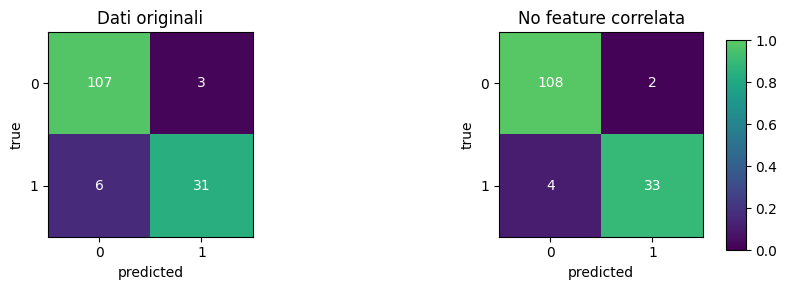

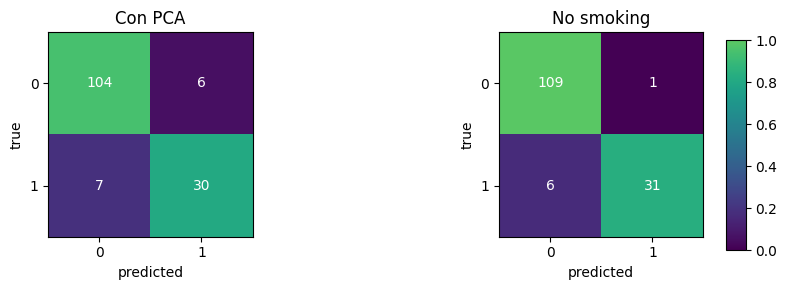

In [36]:
heatMapConstr([cmat_mlp,cmat_mlp_noFeat], ['Dati originali', 'No feature correlata'])
heatMapConstr([cmat_mlp_PCA,cmat_mlp_noSmok], ['Con PCA', 'No smoking'])

## Old (no CV)

In [ ]:
"""
cols={'train_f1':[],'validation_f1':[],'time':[]}
for k in GRID.keys():
    cols[k]=[]
MLPresults=pd.DataFrame(cols)

for g in ParameterGrid(GRID):
    print(g)
    mlp1 = MLPClassifier(early_stopping=True, validation_fraction=val_p, random_state=random_seed)
    start=time.time()
    mlp1.set_params(**g)
    mlp1.fit(X_train,y_train)
    stop=time.time()
    y_pred = mlp1.predict(X_train)
    f1 = f1_score(y_train, y_pred, average='weighted')
    y_pred = mlp1.predict(X_val)
    f1_val = f1_score(y_val, y_pred, average='weighted')
    print("\tTempo impiegato: ",stop-start)
    print("\tF1 score (train): ",f1)
    print("\tF1 score (validation): ",f1_val)
    rowToAppend=g.copy()
    rowToAppend['train_f1']=f1
    rowToAppend['validation_f1']=f1_val
    rowToAppend['time']=stop-start
    MLPresults=pd.concat([MLPresults,pd.Series(rowToAppend).to_frame().T],axis=0,ignore_index=True)
    
#display(MLPresults)
"""

In [ ]:
#MLPresults['layers'] = MLPresults.apply(lambda x: len(x['hidden_layer_sizes']), axis=1)
#MLPresults['layerSize'] = MLPresults.apply(lambda x: x['hidden_layer_sizes'][0], axis=1)